In [1]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"
     

/home/hp/anaconda3/envs/generic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
# sample code snip to train a classification model

def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [4]:
## data loading operations

import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define image size and transformations
image_size = 224  # ResNet-18 standard input size is 224x224
transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(image_size),  # Random resize and crop to 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for pre-trained models
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256 to maintain aspect ratio
        transforms.CenterCrop(image_size),  # Crop to 224x224 from the center
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for pre-trained models
    ]),
}

# Define dataset paths
train_dir = "/media/hp/New Volume/teja_works/tinyml/dataset/seg_train/seg_train"  # Update path to the train directory
test_dir = "/media/hp/New Volume/teja_works/tinyml/dataset/seg_test/seg_test"    # Update path to the test directory

# Create dataset and dataloader for each split (train and test)
dataset = {}
for split in ["train", "test"]:
    if split == "train":
        dataset[split] = ImageFolder(
            root=train_dir,
            transform=transforms["train"],
        )
    else:
        dataset[split] = ImageFolder(
            root=test_dir,
            transform=transforms["test"],
        )

# Create dataloader for each split (train and test)
dataloader = {}
for split in ['train', 'test']:
    dataloader[split] = DataLoader(
        dataset[split],
        batch_size=32,
        shuffle=(split == 'train'),
        num_workers=0,
        pin_memory=True,
    )


In [5]:
# evalution code


@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()# just a random pretrained model

In [6]:
# model init


class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self, classes = 6) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))

    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, classes)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    x = x.mean([2, 3])

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x



model = VGG(classes=6).cuda()     

In [7]:

def get_model_flops(model, inputs):
    num_macs = profile_macs(model, inputs)
    return num_macs
     

def get_model_size(model: nn.Module, data_width=32):
    """
    calculate the model size in bits
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [8]:
fp32_model_accuracy = evaluate(model, dataloader['test'])
fp32_model_size = get_model_size(model)
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

fp32 model has accuracy=17.00%
fp32 model has size=35.20 MiB


In [16]:
## training model for few epochs

from tqdm import tqdm

# Initialize variables for tracking progress
best_sparse_model_checkpoint = dict()
best_accuracy = 0

print(f'Finetuning Fine-grained Pruned Sparse Model')


num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')



# Training loop
for epoch in range(num_finetune_epochs):
    print(f"Epoch [{epoch+1}/{num_finetune_epochs}]")

    # Train phase
    train(model, dataloader['train'], criterion, optimizer, scheduler)

    # Validation phase (optional but recommended)
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during validation
        for inputs, targets in tqdm(dataloader['test'], desc='test', leave=False):
            # Move the data to GPU
            inputs = inputs.cuda()
            targets = targets.cuda()

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Update correct and total counts
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Compute accuracy
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_finetune_epochs}] - Test Accuracy: {accuracy:.2f}%")

    # Save the model if it's the best one so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sparse_model_checkpoint['model_state_dict'] = model.state_dict()
        best_sparse_model_checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        best_sparse_model_checkpoint['epoch'] = epoch
        best_sparse_model_checkpoint['accuracy'] = accuracy
        print(f"Best model updated with accuracy: {best_accuracy:.2f}%")

# Save the best model checkpoint after training is complete
torch.save(best_sparse_model_checkpoint, 'best_finetuned_model.pth')
print(f"Best model saved with accuracy: {best_accuracy:.2f}%")


Finetuning Fine-grained Pruned Sparse Model
Finetuning Fine-grained Pruned Sparse Model
Epoch [1/5]


KeyboardInterrupt: 

In [9]:

from collections import namedtuple

Codebook = namedtuple('Codebook', ['centroids', 'labels'])

In [10]:
# pip install fast-pytorch-kmeans

# KMeans Quantization

In [11]:

from fast_pytorch_kmeans import KMeans

def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        # get number of clusters based on the quantization precision
        # hint: one line of code
        n_clusters = 2**bitwidth
        # use k-means to get the quantization centroids
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)

        # flatten all numbers in the weight to [N_ele, 1]
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)

        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)
    # decode the codebook into k-means quantized tensor for inference
    # hint: one line of code
    quantized_tensor = codebook.centroids[codebook.labels]
    # print(f"{fp32_tensor.shape=}, {codebook.centroids.shape=}, {codebook.labels.shape=}")
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook
     

In [12]:
from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                # print(f"{name=}: {param.shape}")
                # only quantize weight, not bias
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

In [13]:
checkpoint_url = '/media/hp/New Volume/teja_works/tinyml/TinyMLLectureNotes/pruning/best_finetuned_model.pth'
checkpoint = torch.load(checkpoint_url, map_location="cpu")
recover_model = lambda: model.load_state_dict(checkpoint['model_state_dict'])
recover_model()

<All keys matched successfully>

In [14]:
print('Note that the storage for codebooks is ignored when calculating the model size.')
quantizers = dict()
for bitwidth in [8, 4, 2]:
    recover_model()
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

Note that the storage for codebooks is ignored when calculating the model size.
k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=8.80 MiB


    8-bit k-means quantized model has accuracy=81.27%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=4.40 MiB


    4-bit k-means quantized model has accuracy=74.70%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=2.20 MiB


    2-bit k-means quantized model has accuracy=20.77%


In [ ]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    update the centroids in the codebook using updated fp32_tensor
    :param fp32_tensor: [torch.(cuda.)Tensor]
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
        # hint: one line of code
        codebook.centroids[k] = torch.mean(fp32_tensor[codebook.labels==k])

# Quantization aware training

In [15]:
accuracy_drop_threshold = 0.5

fp32_model_accuracy = 81

quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers

for bitwidth in [8, 4, 2]:
    recover_model()
    quantizer = quantizers[bitwidth]
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}% before quantization-aware training ")
    accuracy_drop = fp32_model_accuracy - quantized_model_accuracy
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        Quantization-aware training due to accuracy drop={accuracy_drop:.2f}% is larger than threshold={accuracy_drop_threshold:.2f}%")
        num_finetune_epochs = 5
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        epoch = num_finetune_epochs
        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
            train(model, dataloader['train'], criterion, optimizer, scheduler,
                  callbacks=[lambda: quantizer.apply(model, update_centroids=True)])
            model_accuracy = evaluate(model, dataloader['test'])
            is_best = model_accuracy > best_accuracy
            best_accuracy = max(model_accuracy, best_accuracy)
            print(f'        Epoch {num_finetune_epochs-epoch} Accuracy {model_accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
            accuracy_drop = fp32_model_accuracy - best_accuracy
            epoch -= 1
    else:
        print(f"        No need for quantization-aware training since accuracy drop={accuracy_drop:.2f}% is smaller than threshold={accuracy_drop_threshold:.2f}%")
     

k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=8.80 MiB


KeyboardInterrupt: 

# Linear Quantization

In [16]:

def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

In [17]:

def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    linear quantization for single fp_tensor
      from
        fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    # Step 1: scale the fp_tensor
    scaled_tensor = fp_tensor / scale
    # Step 2: round the floating value to integer value
    rounded_tensor = torch.round(scaled_tensor)

    rounded_tensor = rounded_tensor.to(dtype)

    # Step 3: shift the rounded_tensor to make zero_point 0
    shifted_tensor = rounded_tensor + zero_point

    # Step 4: clamp the shifted_tensor to lie in bitwidth-bit range
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor

In [18]:
def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    get quantization scale for single tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max().item()
    fp_min = fp_tensor.min().item()

    # hint: one line of code for calculating scale
    # [VERY IMPORTANT] quantized_max - quantized_min = 2 ** bitwith - 1
    scale = (fp_max - fp_min) / (quantized_max - quantized_min)
    # hint: one line of code for calculating zero_point
    zero_point = round(quantized_min - fp_min / scale)

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else: # convert from float to int using round()
        zero_point = round(zero_point)
    return scale, int(zero_point)
     

In [19]:
def linear_quantize_feature(fp_tensor, bitwidth):
    """
    linear quantization for feature tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating feature to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [float] scale tensor
        [int] zero point
    """
    scale, zero_point = get_quantization_scale_and_zero_point(fp_tensor, bitwidth)
    quantized_tensor = linear_quantize(fp_tensor, bitwidth, scale, zero_point)
    return quantized_tensor, scale, zero_point

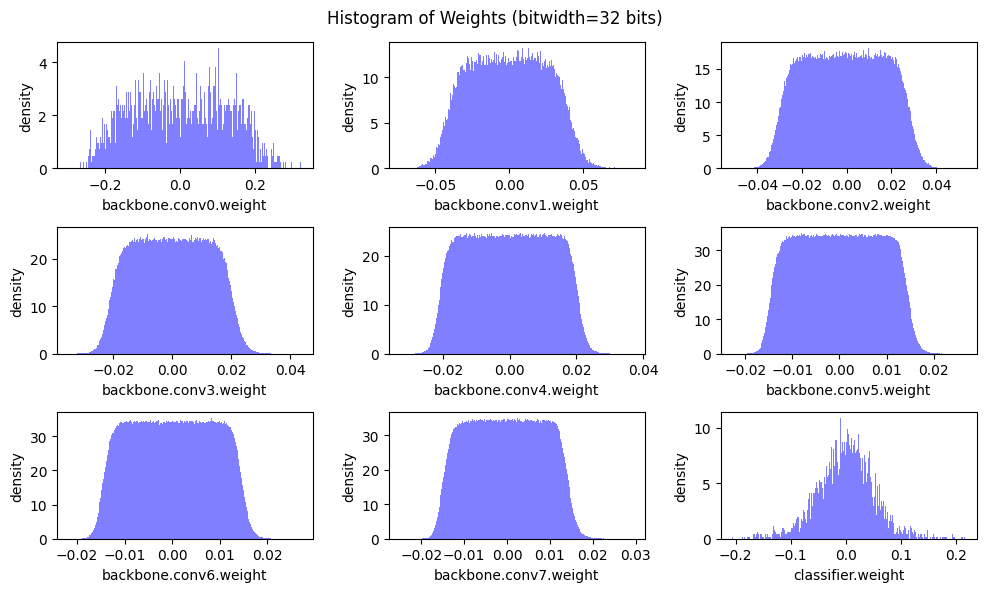

In [20]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

recover_model()
plot_weight_distribution(model)

In [21]:

def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    # we also always make zero_point 0 for weight
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max
     

In [22]:
def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

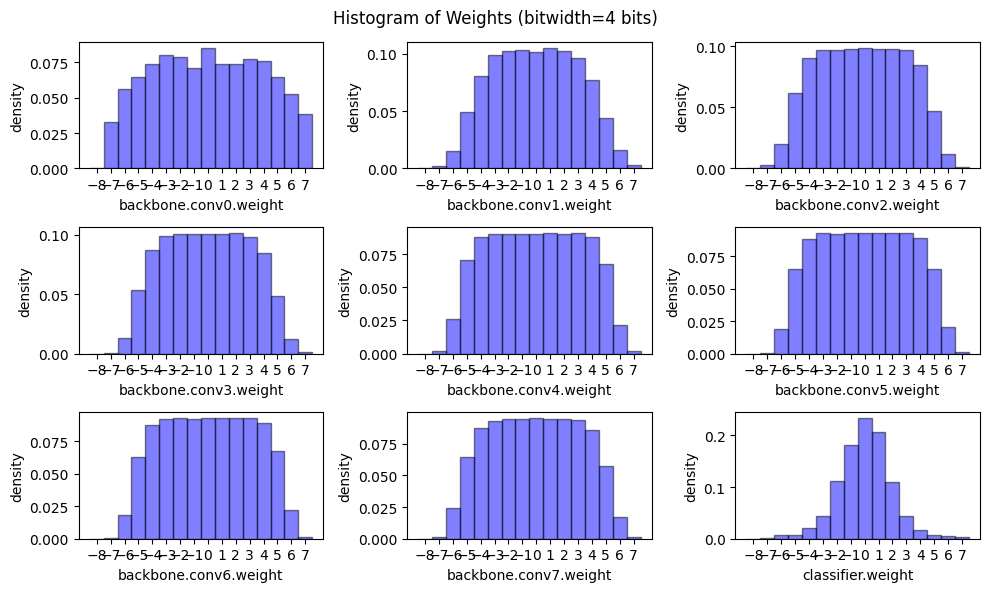

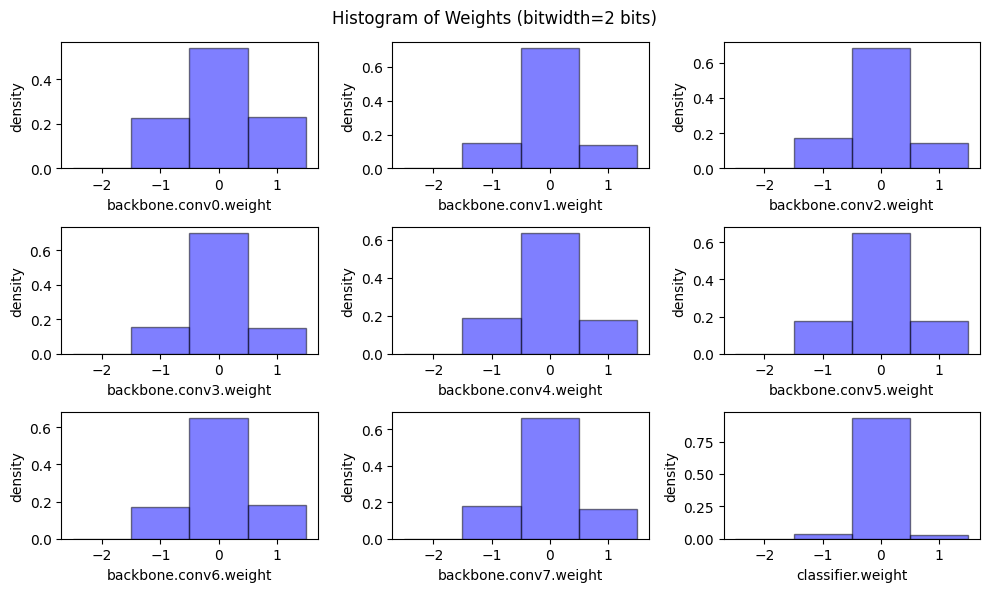

In [23]:
@torch.no_grad()
def peek_linear_quantization():
    for bitwidth in [4, 2]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)
        recover_model()

peek_linear_quantization()

In [24]:

def linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale):
    """
    linear quantization for single bias tensor
        quantized_bias = fp_bias / bias_scale
    :param bias: [torch.FloatTensor] bias weight to be quantized
    :param weight_scale: [float or torch.FloatTensor] weight scale tensor
    :param input_scale: [float] input scale
    :return:
        [torch.IntTensor] quantized bias tensor
    """
    assert(bias.dim() == 1)
    assert(bias.dtype == torch.float)
    assert(isinstance(input_scale, float))
    if isinstance(weight_scale, torch.Tensor):
        assert(weight_scale.dtype == torch.float)
        weight_scale = weight_scale.view(-1)
        assert(bias.numel() == weight_scale.numel())

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code
    bias_scale = input_scale * weight_scale
    ############### YOUR CODE ENDS HERE #################

    quantized_bias = linear_quantize(bias, 32, bias_scale,
                                     zero_point=0, dtype=torch.int32)
    return quantized_bias, bias_scale, 0
     
     
     
     
def shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Linear
        shifted_quantized_bias = quantized_bias - Linear(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum(1).to(torch.int32) * input_zero_point




def quantized_linear(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale):
    """
    quantized fully-connected layer
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.CharIntTensor] quantized output feature (torch.int8)
    """
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: integer-based fully-connected (8-bit multiplication with 32-bit accumulation)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.linear(input.to(torch.int32), weight.to(torch.int32), bias)
    else:
        # current version pytorch does not yet support integer-based linear() on GPUs
        output = torch.nn.functional.linear(input.float(), weight.float(), bias.float())

    # Step 2: scale the output
    output = output.float()
    output *= (input_scale * weight_scale.flatten().view(1, -1) / output_scale)


    # Step 3: shift output by output_zero_point
    output = output + output_zero_point
    ############### YOUR CODE ENDS HERE #################

    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output




def shift_quantized_conv2d_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Conv2d
        shifted_quantized_bias = quantized_bias - Conv(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum((1,2,3)).to(torch.int32) * input_zero_point



def quantized_conv2d(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale,
                     stride, padding, dilation, groups):
    """
    quantized 2d convolution
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param samp: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.(cuda.)CharTensor] quantized output feature
    """
    assert(len(padding) == 4)
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: calculate integer-based 2d convolution (8-bit multiplication with 32-bit accumulation)
    input = torch.nn.functional.pad(input, padding, 'constant', input_zero_point)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # current version pytorch does not yet support integer-based conv2d() on GPUs
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)
    if bias is not None:
        output = output + bias.view(1, -1, 1, 1)


    # Step 2: scale the output
    output = output.float()
    output *= (input_scale * weight_scale.flatten().view(1, -1, 1, 1) / output_scale)

    # Step 3: shift output by output_zero_point
    output += output_zero_point

    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

In [25]:

def fuse_conv_bn(conv, bn):
    # modified from https://mmcv.readthedocs.io/en/latest/_modules/mmcv/cnn/utils/fuse_conv_bn.html
    assert conv.bias is None

    factor = bn.weight.data / torch.sqrt(bn.running_var.data + bn.eps)
    conv.weight.data = conv.weight.data * factor.reshape(-1, 1, 1, 1)
    conv.bias = nn.Parameter(- bn.running_mean.data * factor + bn.bias.data)

    return conv

print('Before conv-bn fusion: backbone length', len(model.backbone))
#  fuse the batchnorm into conv layers
recover_model()
model_fused = copy.deepcopy(model)
fused_backbone = []
ptr = 0
while ptr < len(model_fused.backbone):
    if isinstance(model_fused.backbone[ptr], nn.Conv2d) and \
        isinstance(model_fused.backbone[ptr + 1], nn.BatchNorm2d):
        fused_backbone.append(fuse_conv_bn(
            model_fused.backbone[ptr], model_fused.backbone[ptr+ 1]))
        ptr += 2
    else:
        fused_backbone.append(model_fused.backbone[ptr])
        ptr += 1
model_fused.backbone = nn.Sequential(*fused_backbone)

print('After conv-bn fusion: backbone length', len(model_fused.backbone))
# sanity check, no BN anymore
for m in model_fused.modules():
    assert not isinstance(m, nn.BatchNorm2d)

#  the accuracy will remain the same after fusion
fused_acc = evaluate(model_fused, dataloader['test'])
print(f'Accuracy of the fused model={fused_acc:.2f}%')

Before conv-bn fusion: backbone length 28
After conv-bn fusion: backbone length 20


Accuracy of the fused model=81.00%


In [26]:
# add hook to record the min max value of the activation
input_activation = {}
output_activation = {}

def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ReLU)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))
    return all_hooks

hooks = add_range_recoder_hook(model_fused)
# sample from training data. record the scale and zero point for inference usage.
sample_data = iter(dataloader['train']).__next__()[0]
model_fused(sample_data.cuda())

# remove hooks
for h in hooks:
    h.remove()

In [27]:
class QuantizedConv2d(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 stride, padding, dilation, groups,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.stride = stride
        self.padding = (padding[1], padding[1], padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth


    def forward(self, x):
        return quantized_conv2d(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale,
            self.stride, self.padding, self.dilation, self.groups
            )

class QuantizedLinear(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth

    def forward(self, x):
        return quantized_linear(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale
            )

class QuantizedMaxPool2d(nn.MaxPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based MaxPool
        return super().forward(x.float()).to(torch.int8)

class QuantizedAvgPool2d(nn.AvgPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based AvgPool
        return super().forward(x.float()).to(torch.int8)

# we use int8 quantization, which is quite popular
feature_bitwidth = weight_bitwidth = 8
quantized_model = copy.deepcopy(model_fused)
quantized_backbone = []
ptr = 0
while ptr < len(quantized_model.backbone):
    if isinstance(quantized_model.backbone[ptr], nn.Conv2d) and \
        isinstance(quantized_model.backbone[ptr + 1], nn.ReLU):
        conv = quantized_model.backbone[ptr]
        conv_name = f'backbone.{ptr}'
        relu = quantized_model.backbone[ptr + 1]
        relu_name = f'backbone.{ptr + 1}'

        input_scale, input_zero_point = \
            get_quantization_scale_and_zero_point(
                input_activation[conv_name], feature_bitwidth)

        output_scale, output_zero_point = \
            get_quantization_scale_and_zero_point(
                output_activation[relu_name], feature_bitwidth)

        quantized_weight, weight_scale, weight_zero_point = \
            linear_quantize_weight_per_channel(conv.weight.data, weight_bitwidth)
        quantized_bias, bias_scale, bias_zero_point = \
            linear_quantize_bias_per_output_channel(
                conv.bias.data, weight_scale, input_scale)
        shifted_quantized_bias = \
            shift_quantized_conv2d_bias(quantized_bias, quantized_weight,
                                        input_zero_point)

        quantized_conv = QuantizedConv2d(
            quantized_weight, shifted_quantized_bias,
            input_zero_point, output_zero_point,
            input_scale, weight_scale, output_scale,
            conv.stride, conv.padding, conv.dilation, conv.groups,
            feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
        )

        quantized_backbone.append(quantized_conv)
        ptr += 2
    elif isinstance(quantized_model.backbone[ptr], nn.MaxPool2d):
        quantized_backbone.append(QuantizedMaxPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    elif isinstance(quantized_model.backbone[ptr], nn.AvgPool2d):
        quantized_backbone.append(QuantizedAvgPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    else:
        raise NotImplementedError(type(quantized_model.backbone[ptr]))  # should not happen
quantized_model.backbone = nn.Sequential(*quantized_backbone)

# finally, quantized the classifier
fc_name = 'classifier'
fc = model.classifier
input_scale, input_zero_point = \
    get_quantization_scale_and_zero_point(
        input_activation[fc_name], feature_bitwidth)

output_scale, output_zero_point = \
    get_quantization_scale_and_zero_point(
        output_activation[fc_name], feature_bitwidth)

quantized_weight, weight_scale, weight_zero_point = \
    linear_quantize_weight_per_channel(fc.weight.data, weight_bitwidth)
quantized_bias, bias_scale, bias_zero_point = \
    linear_quantize_bias_per_output_channel(
        fc.bias.data, weight_scale, input_scale)
shifted_quantized_bias = \
    shift_quantized_linear_bias(quantized_bias, quantized_weight,
                                input_zero_point)

quantized_model.classifier = QuantizedLinear(
    quantized_weight, shifted_quantized_bias,
    input_zero_point, output_zero_point,
    input_scale, weight_scale, output_scale,
    feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
)

In [28]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    if extra_preprocess is not None:
        for preprocess in extra_preprocess:
            inputs = preprocess(inputs)

    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [31]:
print(quantized_model)

def extra_preprocess(x):
    # hint: you need to convert the original fp32 input of range (0, 1)
    #  into int8 format of range (-128, 127)
    return (x * 255 - 128).clamp(-128, 127).to(torch.int8)

int8_model_accuracy = evaluate(quantized_model, dataloader['test'],
                               extra_preprocess=[extra_preprocess])
print(f"int8 model has accuracy={int8_model_accuracy:.2f}%")
     

VGG(
  (backbone): Sequential(
    (0): QuantizedConv2d()
    (1): QuantizedConv2d()
    (2): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): QuantizedConv2d()
    (4): QuantizedConv2d()
    (5): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): QuantizedConv2d()
    (7): QuantizedConv2d()
    (8): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): QuantizedConv2d()
    (10): QuantizedConv2d()
    (11): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): QuantizedLinear()
)


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Char